# Part 1:  Building a Machine Learning Pipeline

#Load Dataset

In [ ]:
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd


In [ ]:
X, y = fetch_openml('heart-c', version=2, return_X_y=True, as_frame=True)

# Convert Target Variables

In [ ]:
y = y.map({'P': 1, 'N': 0})

# Data Exploration

In [ ]:
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Number of samples: 303
Number of features: 13


In [ ]:
X.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,male,typ_angina,145,233,t,left_vent_hyper,150,no,2.3,down,0.0,fixed_defect
1,67,male,asympt,160,286,f,left_vent_hyper,108,yes,1.5,flat,3.0,normal
2,67,male,asympt,120,229,f,left_vent_hyper,129,yes,2.6,flat,2.0,reversable_defect
3,37,male,non_anginal,130,250,f,normal,187,no,3.5,down,0.0,normal
4,41,female,atyp_angina,130,204,f,left_vent_hyper,172,no,1.4,up,0.0,normal
5,56,male,atyp_angina,120,236,f,normal,178,no,0.8,up,0.0,normal
6,62,female,asympt,140,268,f,left_vent_hyper,160,no,3.6,down,2.0,normal
7,57,female,asympt,120,354,f,normal,163,yes,0.6,up,0.0,normal
8,63,male,asympt,130,254,f,left_vent_hyper,147,no,1.4,flat,1.0,reversable_defect
9,53,male,asympt,140,203,t,left_vent_hyper,155,yes,3.1,down,0.0,reversable_defect


In [ ]:
print(X.dtypes)

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca           float64
thal        category
dtype: object


Numerical features (int64/float64): age, trestbps, chol, thalach, oldpeak, ca

Categorical features (category dtype):

Ordinal: cp, restecg, slope, thal

Nominal: sex, fbs, exang

In [ ]:
print(X.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          5
thal        2
dtype: int64


7 values are missing, 5 from ca and 2 from thal

binaryClass
1    165
0    138
Name: count, dtype: int64


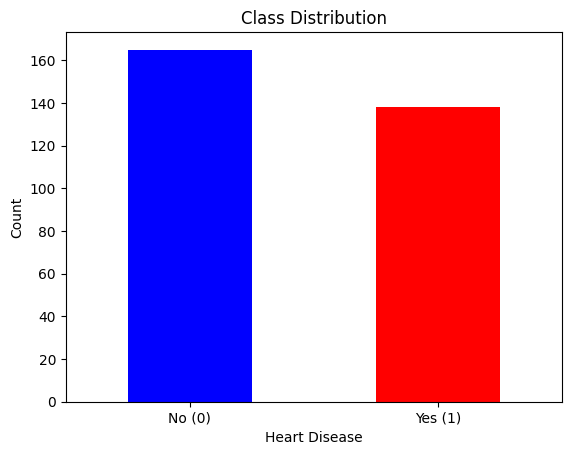

In [48]:
print(y.value_counts())
y.value_counts().plot(kind='bar', title='Class Distribution', color=['blue', 'red'])
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'], rotation=0)
plt.show()

The dataset has 165 samples with heart disease (class 1) and 138 without (class 0), summing up to a total of 303 samples. The classes are slightly imbalanced but not that much, having a 55/45 split. Class imbalance will unlikely be a major issue for this dataset.

In [ ]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X[numerical_features].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


- age ranges from 29 to 77 with a mean of ~54, meaning that the dataset is focusing on middle-aged to older adults, which make sense when we care about heart disease risks.

- trestbps has a mean of ~132 mmHg and a max of 200, suggesting many patients in this dataset have elevated blood pressure.

- chol (cholesterol) has a mean of ~246 mg/dl, which is borderline high, and a max of 564 which is a potential outlier.

- thalach (maximum heart rate achieved) averages ~150 bpm with a reasonable spread, and the min of 71 is notably low.

- oldpeak is heavily right-skewed the mean is ~1.04 but the 25th percentile is 0, meaning many patients have no 'ST depression at all.

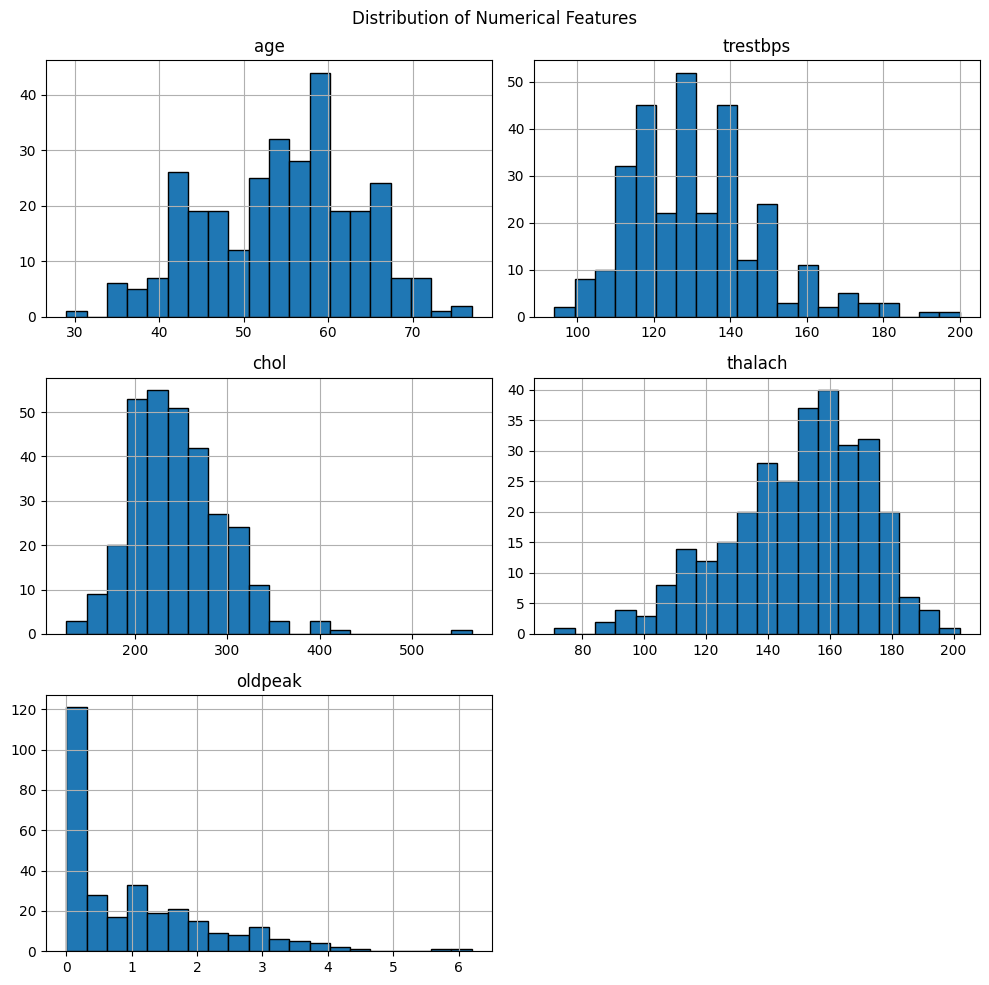

In [46]:
X[numerical_features].hist(bins=20, figsize=(10, 10), edgecolor='black', grid=True)
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

- age is roughly normally distributed with a small right skew, centered around 54-60. This tells us the dataset is mainly composed of middle-aged to older adults, which is expected for a heart disease study.

- trestbps is roughly normally distributed with a slight right skew, with most values between 120-140 mmHg and a few patients with very high blood pressure near 200.

- chol is right-skewed, reach max at around 200-250 mg/dl with a long tail toward 564. This suggests most patients have moderately high cholesterol, but a few have extremely high values that may be outliers.

- thalach is left-skewed, with most patients achieving high maximum heart rates between 140-180 bpm. Lower values may mean reduced activity.

- oldpeak is heavily right-skewed, with the majority of patients having values at or near 0, meaning most patients showed little to no ST depression during exercise, which I confirmed before.

- ca is heavily right-skewed, with most patients having 0 blocked major vessels and very few having 2 or 3, reflecting that severe vessel blockage is relatively uncommon.


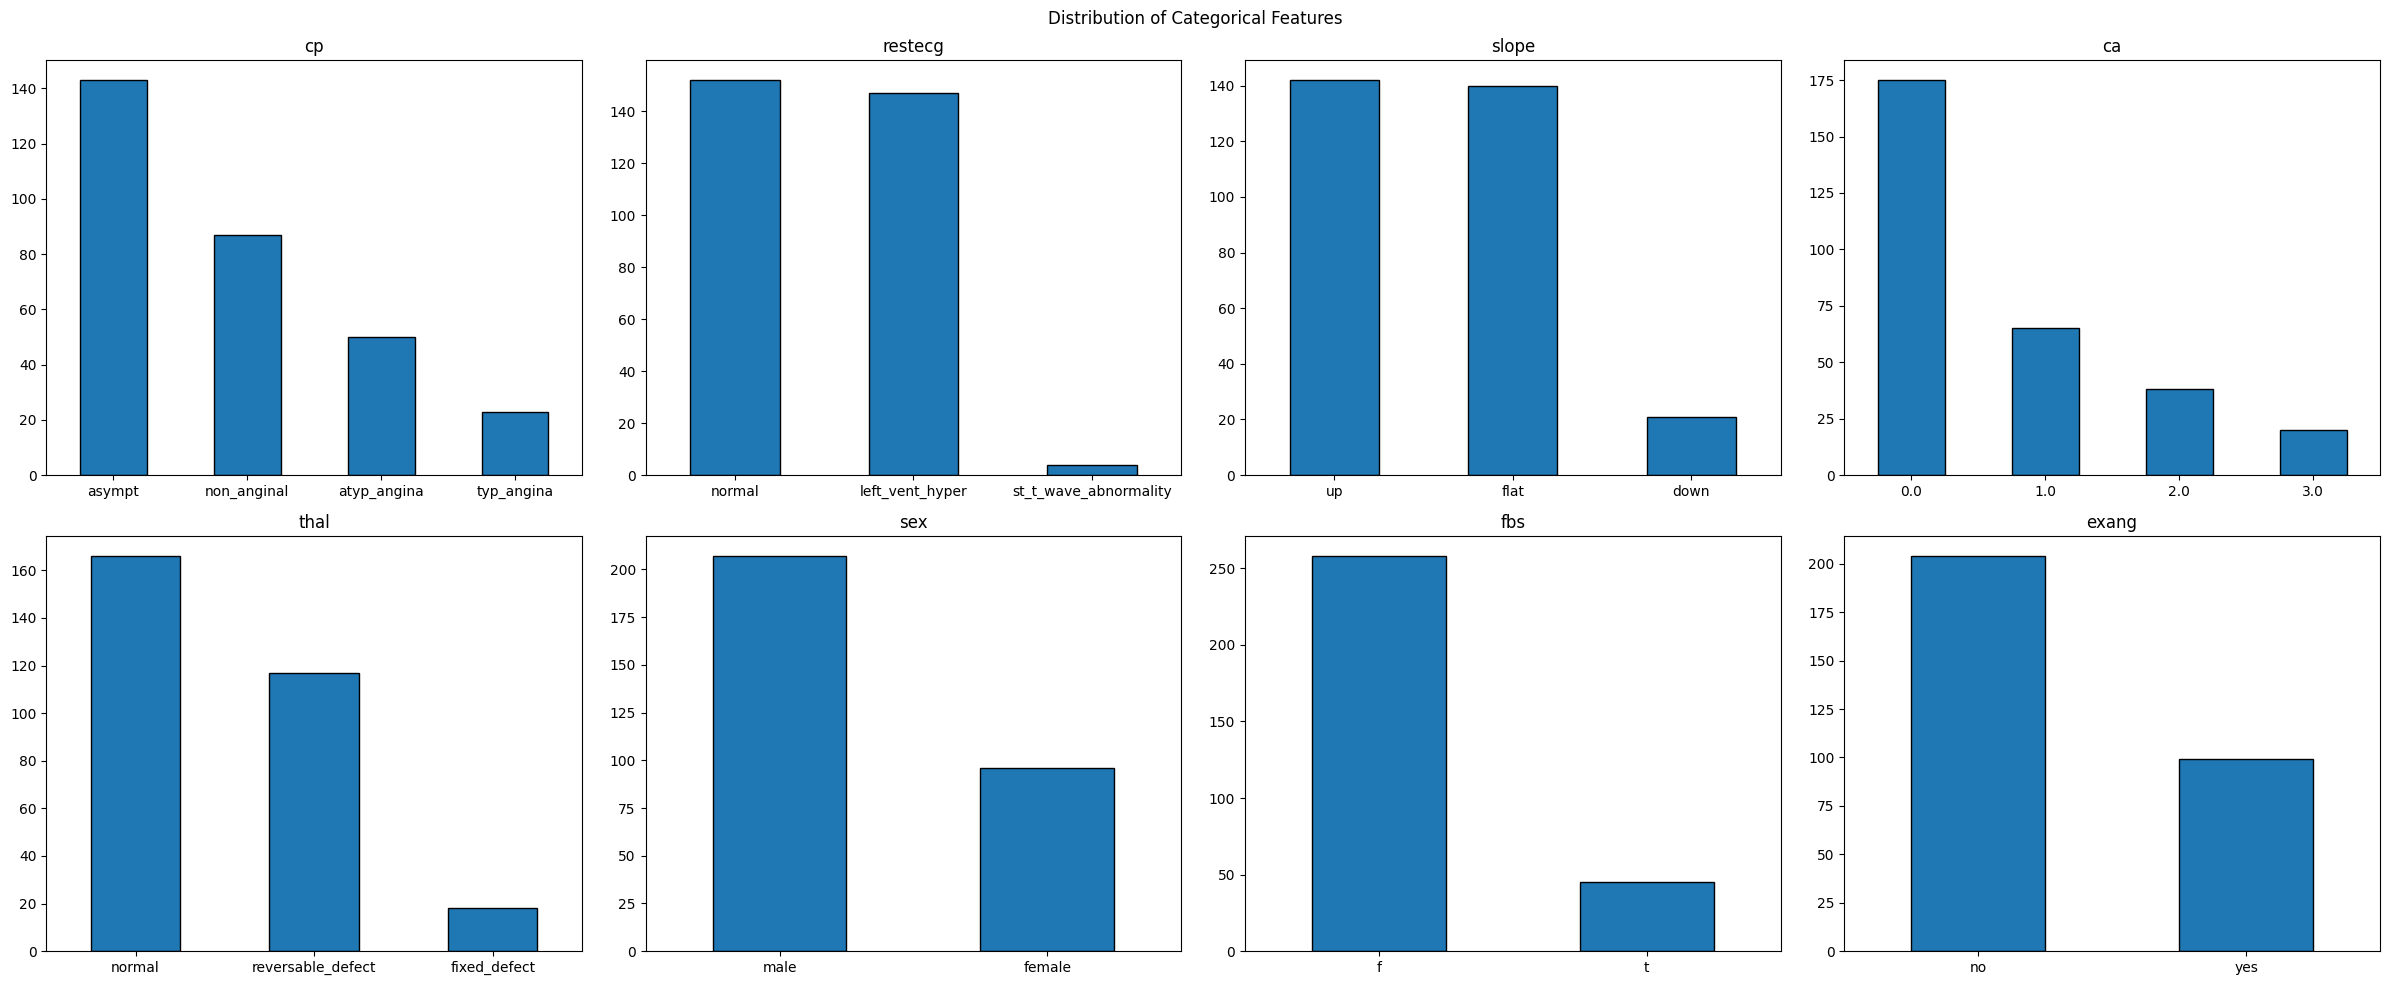

In [ ]:
categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal', 'sex', 'fbs', 'exang']

fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    X[col].value_counts().plot(kind='bar', ax=axes[i], edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=0)

plt.suptitle('Distribution of Categorical Features')
plt.tight_layout()
plt.show()

- cp: Asymptomatic chest pain is by far the most common type, followed by non-anginal pain. Typical angina is the rarest, which is counterintuitive for a heart disease dataset, because that means most patients don't experience the main symptoms but have heart disease, making it harder to detect

- restecg: Normal and left ventricular hypertrophy are equally common,
  while st_t_wave_abnormality is very rare.

- slope: Up and flat slopes are roughly equally common, while downward slope is much less frequent.

- ca: The majority of patients have 0 blocked vessels, with fewer patients having 1, 2, or 3 blocked vessels.

- thal: Normal is the most common thalassemia type, followed by reversable defect. Fixed defect is rare.

- sex: The dataset is male dominated, with roughly twice as many male patients as female.

- fbs: The majority of patients have fasting blood sugar below 126 mg/dl,
  meaning high fasting blood sugar is uncommon in this dataset.

- exang: Most patients did not experience chest pain during exercise, but about 100 patients did.

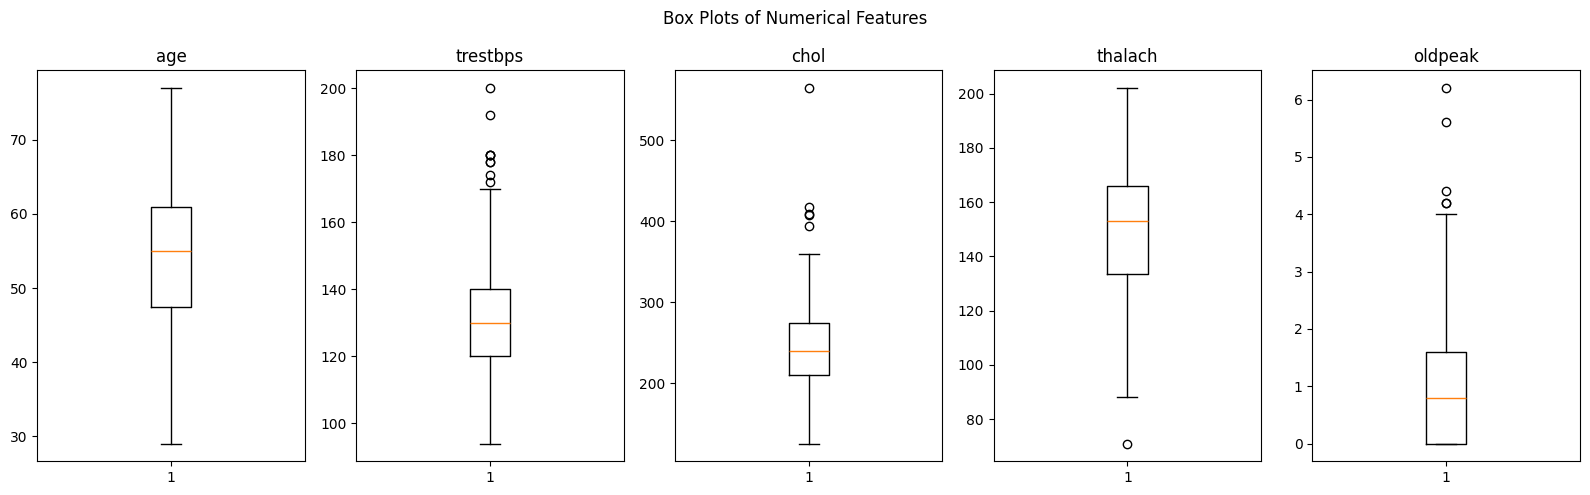

In [ ]:
fig, axes = plt.subplots(1, len(numerical_features), figsize=(16, 5))

for i, col in enumerate(numerical_features):
    axes[i].boxplot(X[col].dropna())
    axes[i].set_title(col)

plt.suptitle('Box Plots of Numerical Features')
plt.tight_layout()
plt.show()

- age: No significant outliers. Values range reasonably from 29 to 77.

- trestbps: Several outliers on the high end, with a few patients having
  blood pressure above 170-200 mmHg.

- chol: One extreme outlier near 564 mg/dl, and a few others above 400.
  Most patients have cholesterol between 200-300.

- thalach: One outlier on the low end (~70 bpm), indicating one patient
  with an unusually low maximum heart rate.

- oldpeak: Two clear outliers above 6, with a few others above 4.
  Most patients have values close to 0.

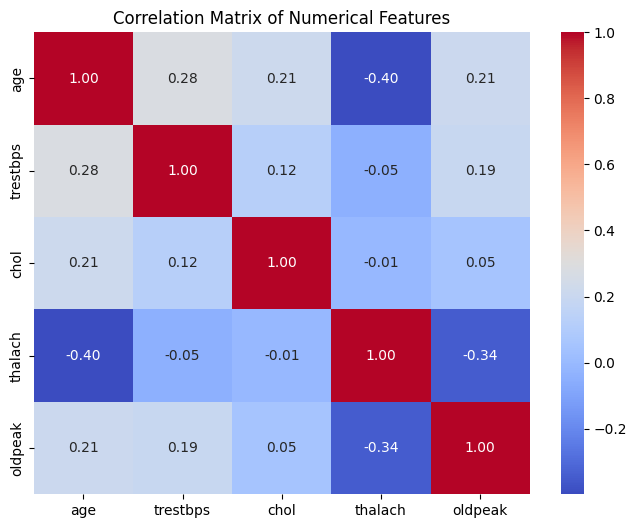

In [ ]:
corr_matrix = X[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

- age and thalach (-0.40): Older patients tend to have a lower maximum heart rate.

- thalach and oldpeak (-0.34): Patients with higher heart rates tend to have
  less ST depression.

- age and trestbps (0.28): Blood pressure increases slightly with age.

- No features are strongly correlated with each other. This can be good when we want to build a ML model

oldpeak    -0.430696
age        -0.225439
trestbps   -0.144931
chol       -0.085239
thalach     0.421741
Name: target, dtype: float64


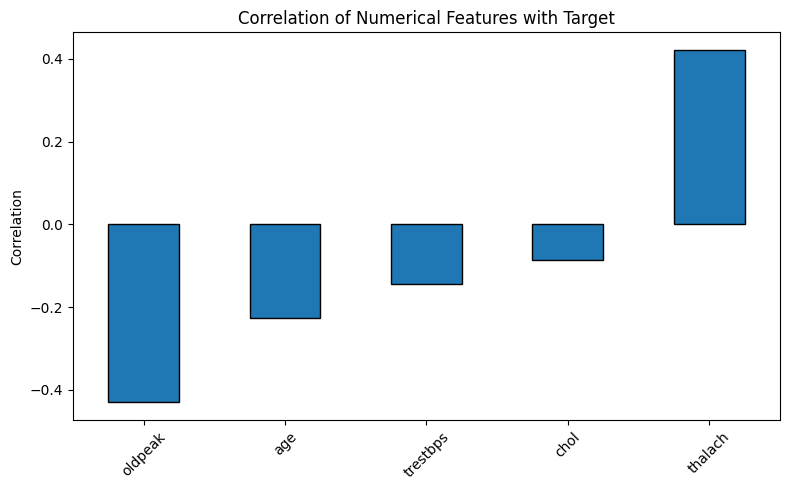

In [ ]:
df_num = X[numerical_features].copy()
df_num['target'] = y.values

correlations = df_num.corr()['target'].drop('target').sort_values()
print(correlations)

correlations.plot(kind='bar', figsize=(8, 5), edgecolor='black')
plt.title('Correlation of Numerical Features with Target')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- thalach (0.42): Patients with heart disease tend to have higher maximum heart rates. It is the most useful numerical feature for prediction.

- oldpeak (-0.43): Patients with more ST depression are less likely to have heart disease. Also very useful for prediction.

- age (-0.23): Older patients are slightly less likely to have heart disease in this dataset.

- trestbps (-0.14) and chol (-0.09): These features look very similar between patients with and without heart disease, its not a very valuable feature to use.

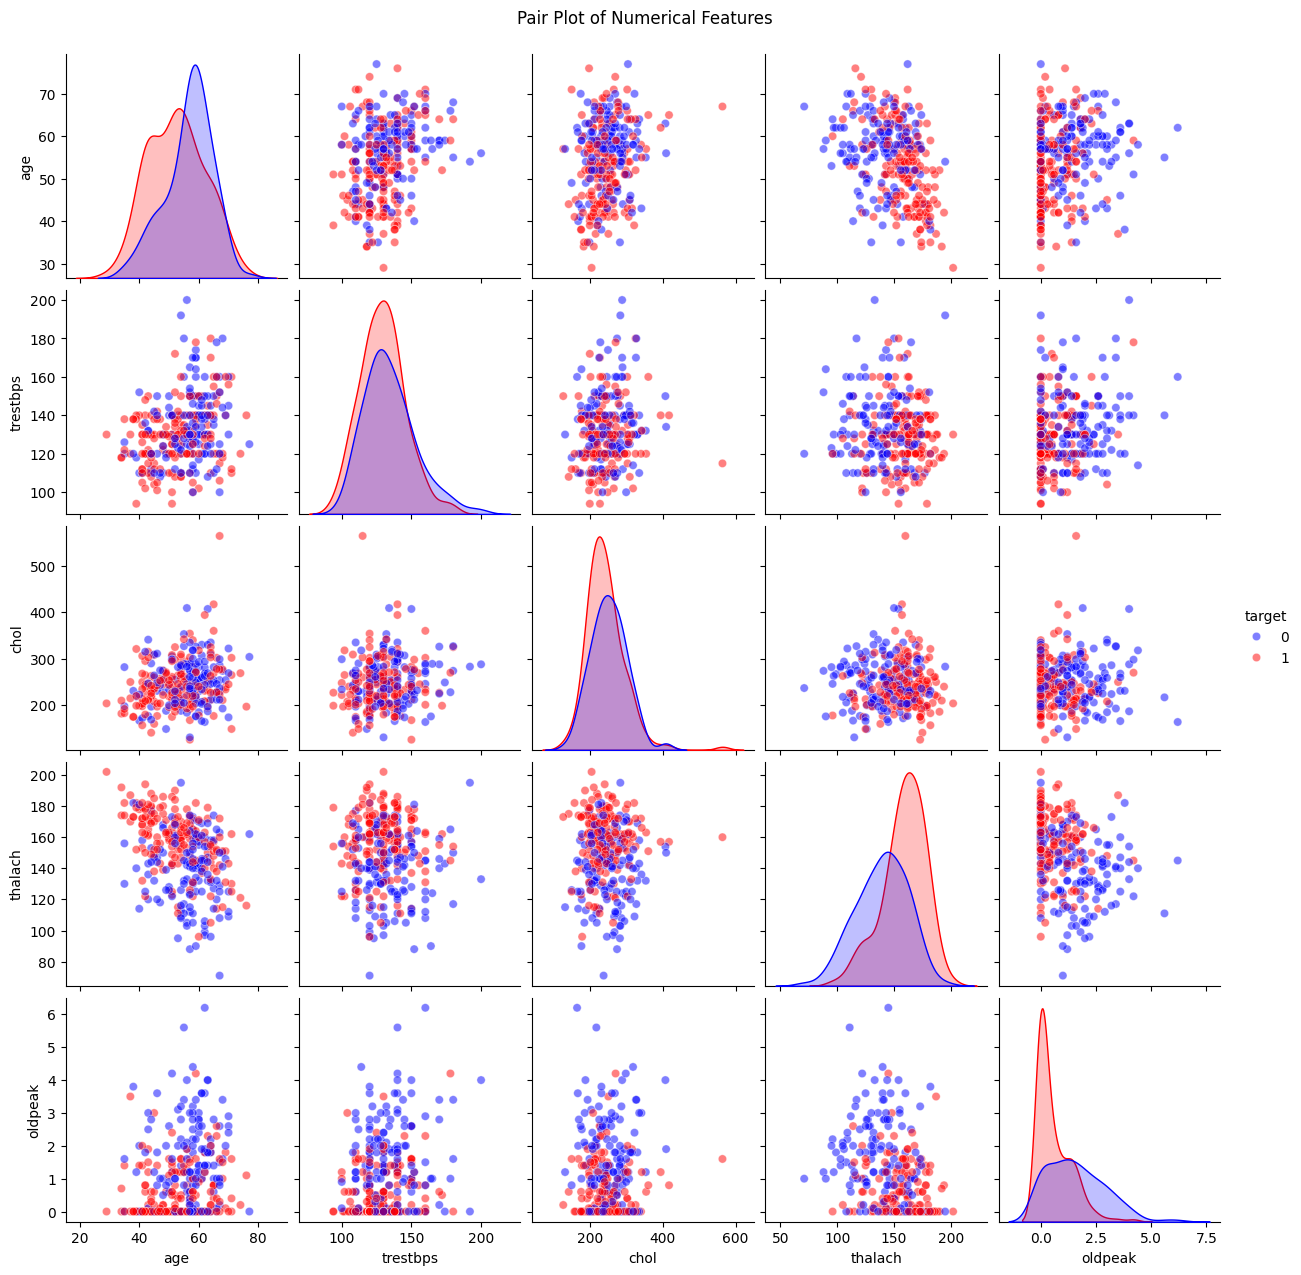

In [ ]:
df_pair = X[numerical_features].copy()
df_pair['target'] = y.values

sns.pairplot(df_pair, hue='target', palette={0: 'blue', 1: 'red'}, plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

Relationships:
- As age increases, thalach decreases. Older patients have lower maximum heart rates.
- Most other feature combinations show no clear relationship.

Separability:
- thalach and oldpeak show the best separation between classes. Patients with heart disease have higher thalach and lower oldpeak values.
- age shows mild separation. Heart disease patients tend to be slightly older.
- trestbps and chol show almost no separation between classes, with red and blue
  points heavily mixed throughout.
- Overall, the classes are not clearly separable using numerical features alone,
  meaning that categorical features are important for prediction.

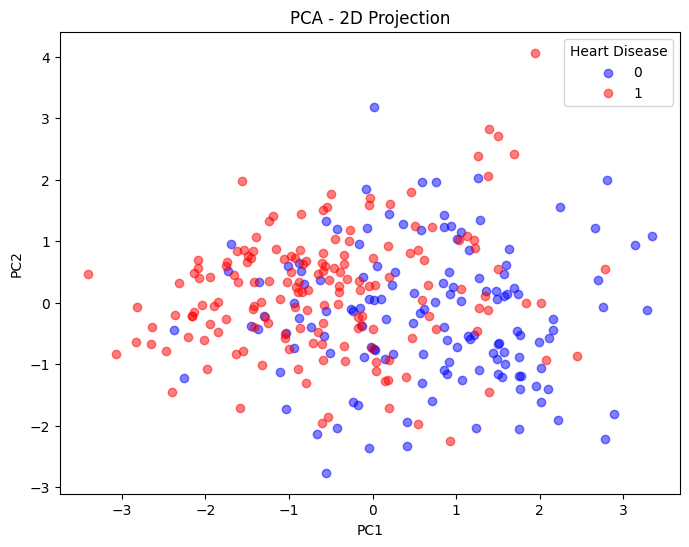

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_features].dropna())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    mask = y.values == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=str(label), alpha=0.5, color=color)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - 2D Projection')
plt.legend(title='Heart Disease')
plt.show()

Key Patterns:
- thalach and oldpeak are the most predictive features, showing the best separation between heart disease and healthy patients.
- Older patients tend to have lower maximum heart rates.
- Most patients are asymptomatic, meaning they show no chest pain despite having heart disease.
- The dataset is male-dominated, with twice as many male patients as female.

Anomalies:
- One patient has an extremely high cholesterol value of 564 mg/dl, which is a likely outlier.
- Several patients have very high blood pressure (above 170 mmHg).
- A few patients have unusually high oldpeak values (above 6).

Noteworthy Characteristics:
- The dataset is small which may limit model performance.
- The classes are slightly imbalanced but not that much.
- 5 missing values exist in the ca feature.
- trestbps and chol showed very weak correlation with the target, meaning they may not be very useful for prediction.
- PCA showed that the classes are not clearly separable using numerical features alone, suggesting categorical features will also be important for the model.

# Data Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 242
Test set size: 61


In [ ]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
ordinal_features = ['cp', 'restecg', 'slope', 'ca', 'thal']
nominal_features = ['sex', 'fbs', 'exang']

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Ordinal pipeline
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Nominal pipeline
nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all pipelines
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('ordinal', ordinal_pipeline, ordinal_features),
    ('nominal', nominal_pipeline, nominal_features)
])

# Full pipeline with model
model = LogisticRegression(max_iter=1000)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [ ]:
full_pipeline.fit(X_train, y_train)

train_accuracy = full_pipeline.score(X_train, y_train)
test_accuracy = full_pipeline.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Training accuracy: 0.8678
Test accuracy: 0.8033


- The model achieves a training accuracy of 86.78% and a test accuracy of 80.33%.
- The small gap between training and test accuracy suggests the model is appropriately fitting, it is not memorizing the training data nor is it too simple to learn the patterns.

# Model Comparison

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'MLP Classifier': MLPClassifier(max_iter=2000, random_state=42)
}

results = []

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()
    training_time = end - start

    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)

    results.append({
        'Model': model_name,
        'Training Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Training Time (s)': round(training_time, 4)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

              Model  Training Accuracy  Test Accuracy  Training Time (s)
Logistic Regression             0.8678         0.8033             0.1812
K-Nearest Neighbors             0.8554         0.8361             0.1306
      Random Forest             1.0000         0.8361             0.5647
     MLP Classifier             1.0000         0.7705             3.2334


Observations Discussion:

- K-Nearest Neighbors performs best on the test set (83.61%), with a small gap
  between training and test accuracy, suggesting it is appropriately fitting.

- Random Forest achieves perfect training accuracy (100%) but drops to 83.61%
  on the test set, meaning it is overfitting, it memorized the training data but doesn't generalize as well to new data.

- MLP Classifier also achieves perfect training accuracy (100%) but has the lowest test accuracy (77.05%), it has the most severe form of overfitting.

- Logistic Regression has the most balanced result with no signs of overfitting, but has a slightly lower test accuracy than KNN and Random Forest.

# Part 2: Custom Estimators

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist
import numpy as np

from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
class CentroidClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, distance_metric='euclidean'):
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.centroids_ = np.array([
            X[y == c].mean(axis=0) for c in self.classes_
        ])
        return self

    def predict(self, X):
        distances = cdist(X, self.centroids_, metric=self.distance_metric)
        closest = np.argmin(distances, axis=1)
        return self.classes_[closest]

In [ ]:
X_iris, y_iris = load_iris(return_X_y=True)
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42
)

for metric in ['euclidean', 'cityblock']:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', CentroidClassifier(distance_metric=metric))
    ])
    pipeline.fit(X_train_iris, y_train_iris)
    accuracy = pipeline.score(X_test_iris, y_test_iris)
    print(f"Distance metric: {metric}, Test accuracy: {accuracy:.4f}")

Distance metric: euclidean, Test accuracy: 0.9333
Distance metric: cityblock, Test accuracy: 0.9667


- Euclidean distance got 93.33% accuracy
- Manhattan distance got 96.67% accuracy

Manhattan distance worked slightly better on this dataset. Both scores are high, which means the custom classifier works well. The Iris dataset is relatively easy to classify, so high accuracy is expected.